In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import sys
sys.path.append("../../Fingers-Gesture-Recognition")
import Source.fgr.models as models
from Source.fgr.pipelines import Data_Pipeline
from Source.fgr.data_manager import Data_Manager




/Users/rufaelmarew/opt/anaconda3/envs/tau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Directories
DATA_DIR = '../../data/'
FIG_DIR = '../../figures/'

Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

In [10]:
# pipeline definition and data manager creation
data_path = Path(DATA_DIR+'doi_10')
pipeline = Data_Pipeline(base_data_files_path=data_path, features_extraction_method="RMS")  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = 1
dm = Data_Manager([subject], pipeline)
print(dm.data_info())

dataset = dm.get_dataset(experiments=[f'{subject:03d}_1_1'])
data = dataset[0]
labels = dataset[1]

labels = np.char.strip(labels, '_0123456789')
# data = data.reshape(data.shape[0],4,4)
data.shape

Available experiments in the data manager: ['001_2_3', '001_2_2', '001_1_3', '001_1_1', '001_2_1', '001_1_2']
Experiments format is: subject_session_position
None
Experiments in datasets: ['001_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/1 [00:00<?, ?exp/s]/Users/rufaelmarew/Documents/tau/project/Generalised_FGR_using_EMG/notebooks/../../Fingers-Gesture-Recognition/Source/fgr/data_manager.py:387: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_edf_emg = raw_edf.copy().pick_channels(set(names))


Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.862, in the experiment: 001_1_1
(2521, 16, 2400)


Loading experiments datasets: 100%|██████████| 1/1 [00:08<00:00,  8.70s/exp]

finished extracting the dataset


(2521, 1, 4, 4)

[553, 608, 568, 494, 663, 546, 444, 537, 447, 600]


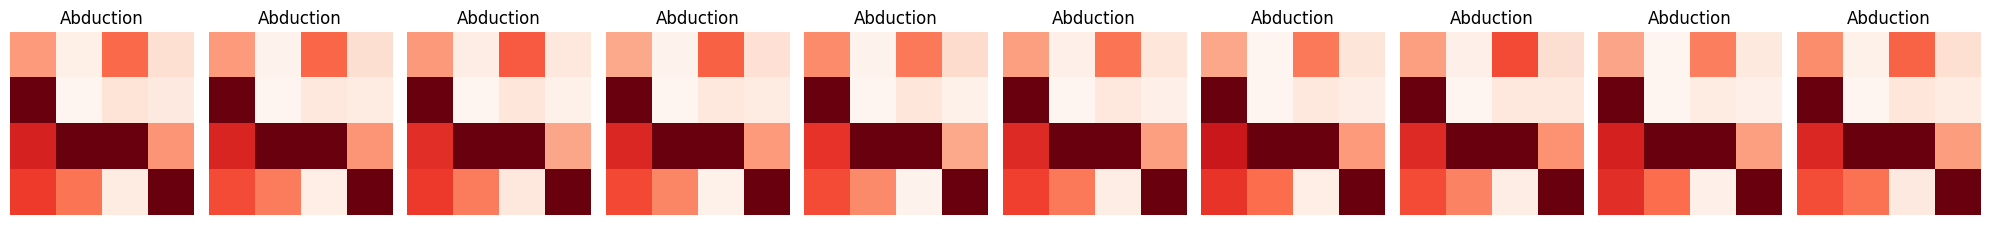

[904, 888, 889, 997, 1044, 901, 1166, 968, 1121, 1157]


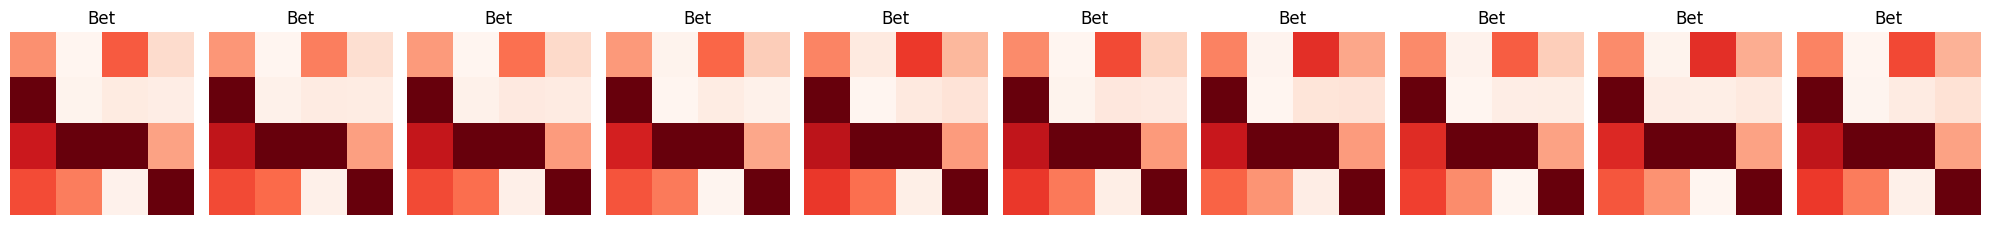

[826, 851, 796, 755, 762, 762, 806, 762, 773, 844]


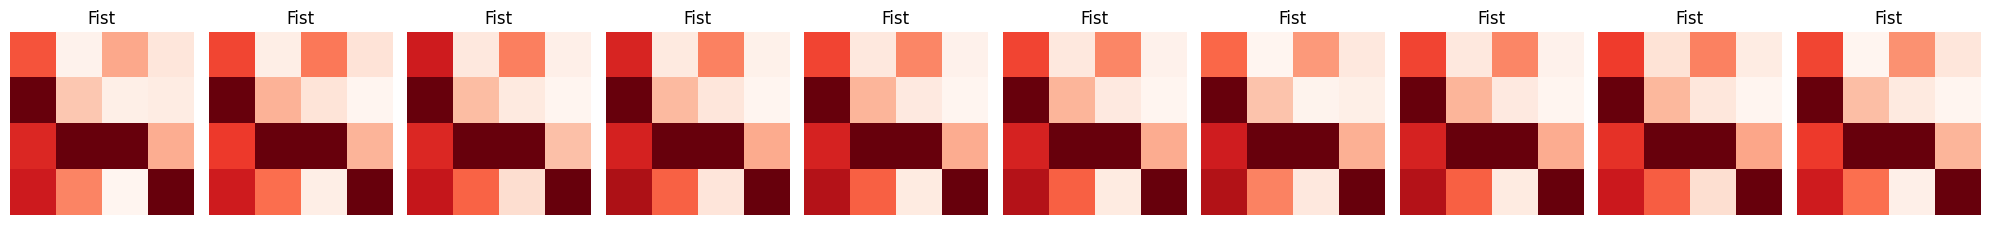

[1206, 1327, 1398, 1289, 1385, 1256, 1189, 1211, 1305, 1300]


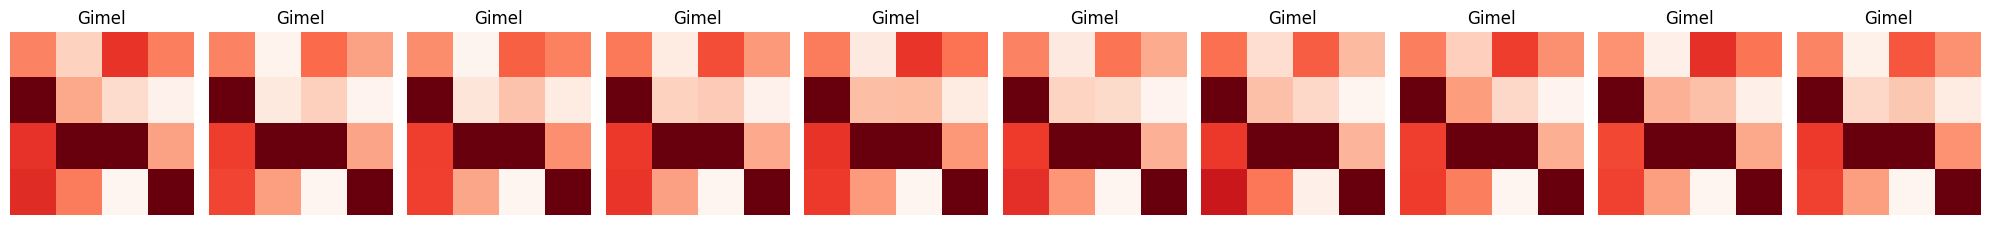

[1656, 1436, 1578, 1499, 1505, 1476, 1543, 1473, 1634, 1480]


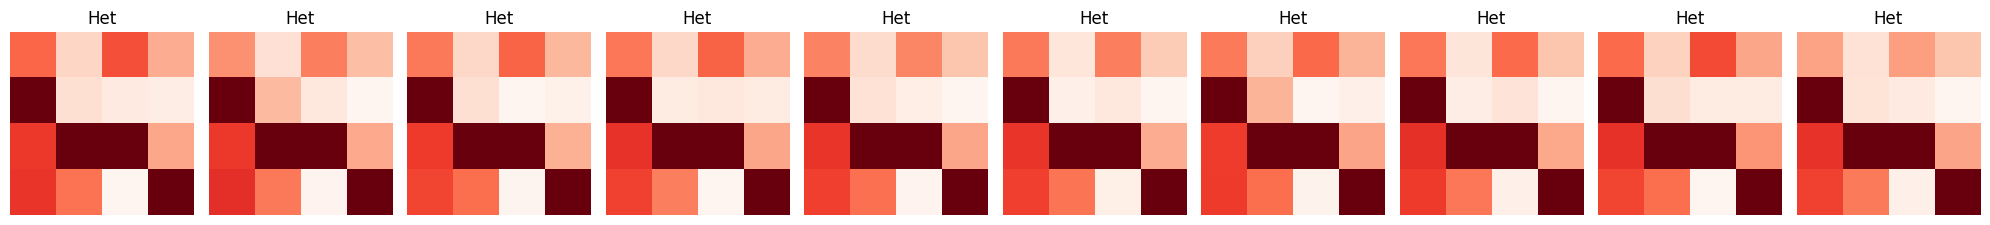

[2159, 1940, 2064, 1979, 2026, 2141, 2025, 2029, 2013, 2174]


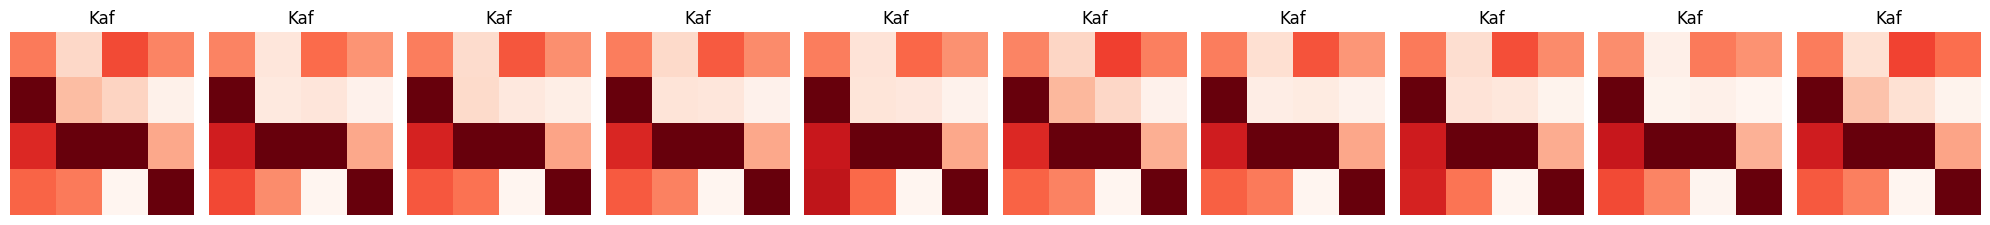

[2390, 2307, 2321, 2498, 2257, 2376, 2515, 2331, 2349, 2476]


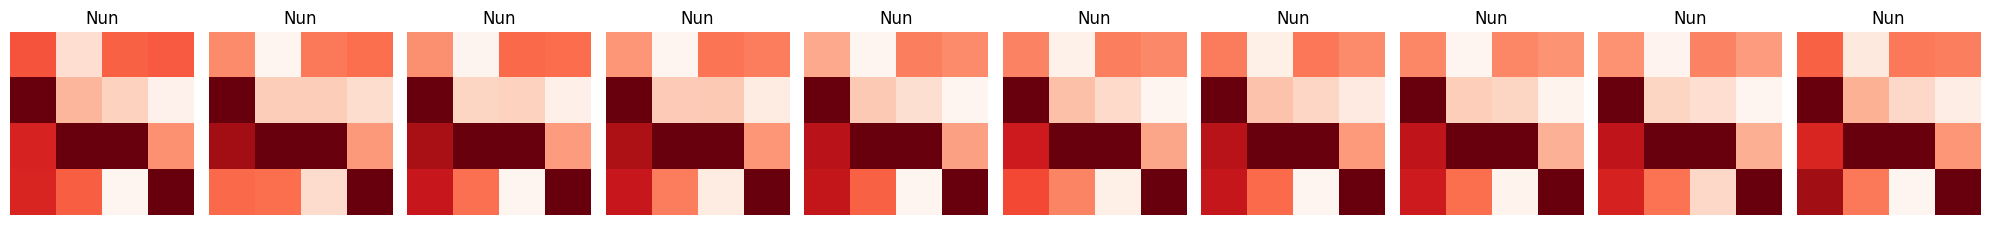

[1824, 1794, 1731, 1810, 1874, 1877, 1724, 1884, 1781, 1754]


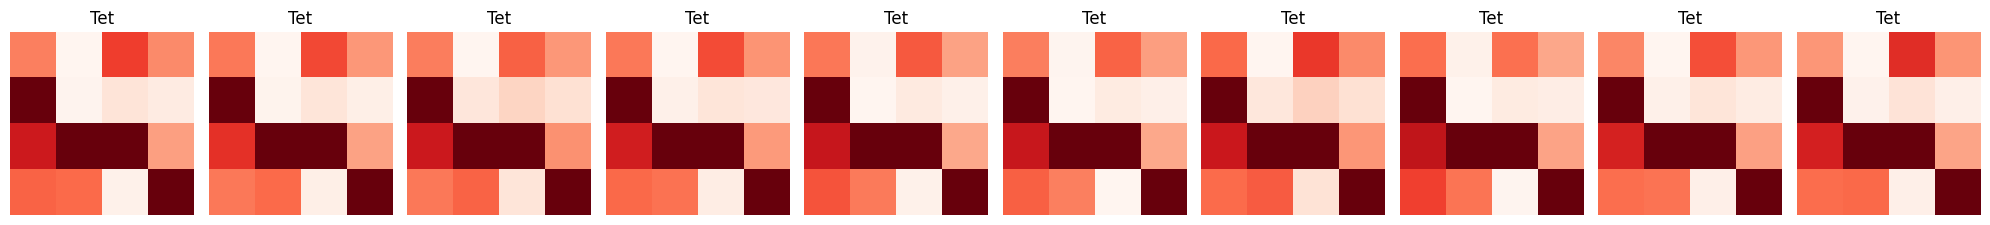

[244, 302, 433, 256, 433, 335, 250, 367, 347, 351]


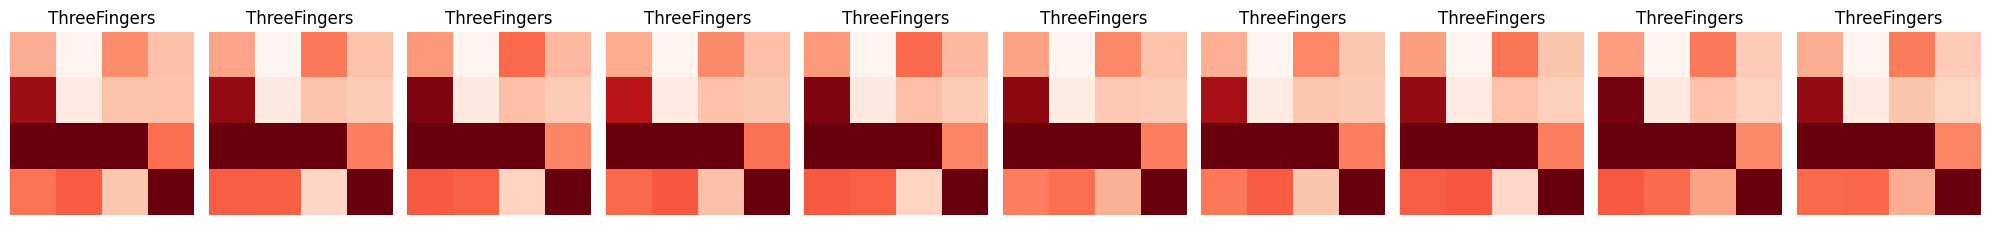

[93, 180, 207, 15, 134, 188, 147, 5, 149, 163]


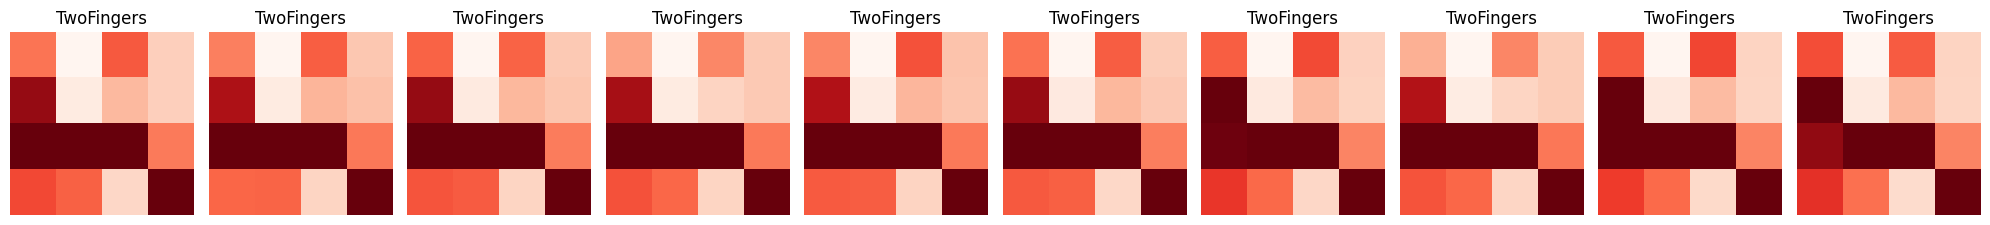

In [11]:
from random import randint, choices
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# visualize 10 images from each class
scaler = StandardScaler()
for i in np.unique(labels):
    sample = choices([j for j in range(len(labels)) if labels[j] == i], k=10)
    print(sample)
    #create figure with subplots with figsize
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
    
    # rms plots
    for index, k in enumerate(sample):
        
        axes[index].imshow(data[k].squeeze(0), cmap='Reds')
        axes[index].set_title(labels[k])
        axes[index].axis('off')
    
    plt.tight_layout()
    plt.show()

   
    

/var/folders/kl/j_5px5k97039f8mqf1tztckw0000gn/T/ipykernel_9439/2998853574.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=label)


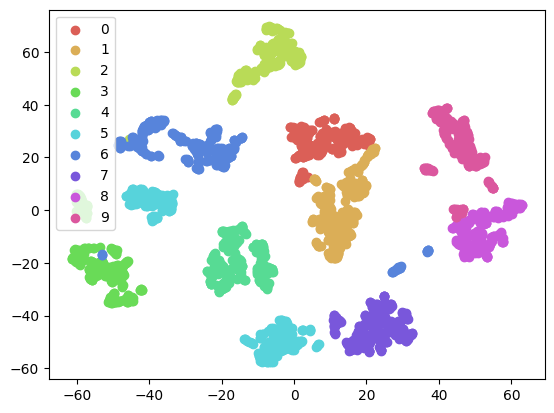

In [12]:
#tsne plot for h wavelet
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
e = LabelEncoder()
X_2d = tsne.fit_transform(data.reshape(data.shape[0],-1))
labels = e.fit_transform(labels)

target_names = np.unique(labels)
target_ids = range(len(target_names))
colors = sns.color_palette('hls', len(target_names))

for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=label)
plt.legend()
plt.show()



In [ ]:
#### ICA ####
from sklearn.decomposition import FastICA
from sklearn.preprocessing import LabelEncoder

ica = FastICA(n_components=16, random_state=0)
e = LabelEncoder()



In [2]:
## train LSTM model on data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                 num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch__first=True)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        # input dim = (batch_size, seq_len, input_size)
        lstm_out, self.hidden = self.lstm(input)
 
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    epoch_loss = 0
    for batch_idx, (data, (target, _)) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)

def test(model, device, test_loader, optimiser, epoch):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, (target,_)) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    return epoch_loss / len(test_loader), correct / len(test_loader.dataset)

In [ ]:
sys.path.append("../")
from dataset import emgdata
from torch.utils.data import random_split, DataLoader

device = 'cuda'
batch_size = 64
input_dim = 16

data = emgdata(data_dir=DATA_DIR+'doi', subjects=[1], pos=[1], sessions=[1])

train_data, test_data = random_split(data, [int(len(data)*0.8), len(data)-int(len(data)*0.8)])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = LSTM(input_dim, 32, batch_size)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader, optimizer, epoch)
    print(f'Epoch: {epoch} Train Loss: {train_loss:.3f} Test Loss: {test_loss:.3f} Test Accuracy: {accuracy:.3f}')



